In [81]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


## Step 1: Define Functions

In [82]:
def normalize(df):
    df["num_photos"] = df["photos"].apply(len)
    df["num_features"] = df["features"].apply(len)
    df["num_description_words"] = df["description"].apply(lambda x: len(x.split(" ")))
    df["created"] = pd.to_datetime(df["created"])
    df["created_year"] = df["created"].dt.year
    df["created_month"] = df["created"].dt.month
    df["created_day"] = df["created"].dt.day
    featureNew = preprocessing.LabelEncoder()
    featureNew.fit(list(df['manager_id'].values))
    df['manager_id'] = featureNew.transform(list(df['manager_id'].values))
    featureNew = preprocessing.LabelEncoder()
    featureNew.fit(list(df['building_id'].values))
    df['building_id'] = featureNew.transform(list(df['building_id'].values))

def manager_skill(x_train, y_train):
    temp = pd.concat([x_train.manager_id, pd.get_dummies(y_train)], axis=1).groupby('manager_id').mean()
    temp['count'] = x_train.groupby('manager_id').count().iloc[:,0]
    temp['manager_skill'] = temp['high']*2 + temp['medium']    
    return temp

def mean_skill(temp):
    unranked_managers_ixes = temp['count']<5
    ranked_managers_ixes = ~unranked_managers_ixes
    mean_values = temp.loc[ranked_managers_ixes, ['high','low','medium','manager_skill']].mean()
    temp.loc[unranked_managers_ixes,['high','low','medium','manager_skill']] = mean_values.values  
    return mean_values

def price_per_bedroom(x):
    x['price_per_bedroom']=0;
    x.loc[:, 'price_per_bedroom'] = x.apply(lambda row: valuation_formula(row['bedrooms'], row['price']), axis=1)

def bedratiobath(x):
    x['bed_bath_ratio']=0;
    x.loc[:, 'bed_bath_ratio'] = x.apply(lambda row: valuation_formula(row['bathrooms'], row['bedrooms']), axis=1)
    
def valuation_formula(x, y):
    if x>0:
        return y/x
    else:
        return y

## Step 2: Prepare Data

#### Normalize data frame

In [83]:
df = pd.read_json("train.json")
normalize(df) 

#### Adding interest_level to original features

In [84]:
original_features = ["bathrooms", "bedrooms", "latitude", "longitude", "price",
                   "num_photos", "num_features", "num_description_words",
                   "created_year", "created_month", "created_day", "manager_id","building_id"]

x = df[original_features]
target_num_map = {'high':0, 'medium':1, 'low':2}
y = np.array(df['interest_level'].apply(lambda x: target_num_map[x]))

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.33)

In [85]:
print('x_train', x_train.shape)
print('y_train', y_train.shape)
print('x_val', x_val.shape)
print('y_val', y_val.shape)

x_train (33065, 13)
y_train (33065,)
x_val (16287, 13)
y_val (16287,)


#### Visulizing training data

In [86]:
print(x_train.head())
x_train.to_csv("xtrain.csv")

        bathrooms  bedrooms  latitude  longitude  price  num_photos  \
71822         1.0         0   40.7574   -73.9681   2195           5   
123179        1.0         1   40.7488   -73.9734   4565           0   
119880        1.0         1   40.7454   -73.9776   3850           7   
14570         1.0         2   40.7617   -73.9618   2850           5   
91182         1.0         1   40.7323   -74.0023   2690           4   

        num_features  num_description_words  created_year  created_month  \
71822              2                    108          2016              5   
123179            12                      1          2016              4   
119880            10                    120          2016              4   
14570              0                     67          2016              6   
91182              1                     26          2016              4   

        created_day  manager_id  building_id  
71822            20        1826         5157  
123179            5   

In [87]:
current_features = ["bathrooms", "bedrooms", "latitude", "longitude", "price",
                   "num_photos", "num_features", "num_description_words",
                   "created_year", "created_month", "created_day", 'high','low','medium',
                   "building_id",'manager_id']

## Step 3: Make Prediction 

### Method : Machine Learning Model -- Gradient Boosting Classifier 

#### Train model

In [88]:
these_features = [f for f in current_features if f not in ["created_year", 'high','low','medium']]
classification = GradientBoostingClassifier(n_estimators=2000)
classification.fit(x_train[these_features], y_train)
y_val_pred = classification.predict_proba(x_val[these_features])
log_loss(y_val, y_val_pred)

0.5863068504399482

In [89]:
preds = classification.predict(x_val[these_features])

#### Visulizing the predict and real data

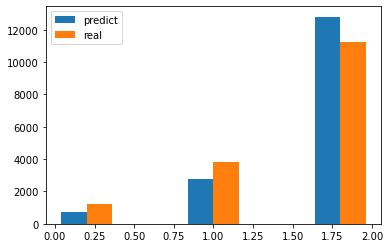

In [90]:
bins = np.linspace(0, 2, 6)
data = np.vstack([preds, y_val]).T
plt.hist(data, bins, alpha=1, label=['predict','real'])
plt.legend(loc='upper left')
plt.show()

#### Create  classification report and heatmap

              precision    recall  f1-score   support

        high       0.30      0.52      0.38       704
      medium       0.37      0.50      0.43      2774
         low       0.92      0.81      0.86     12809

    accuracy                           0.74     16287
   macro avg       0.53      0.61      0.56     16287
weighted avg       0.80      0.74      0.76     16287



<AxesSubplot:>

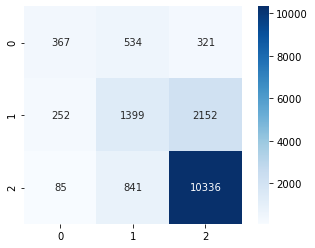

In [91]:
from sklearn.metrics import classification_report
from sklearn.ensemble import GradientBoostingClassifier

from sklearn import metrics
import seaborn as sns

target_names = ['high', 'medium', 'low']
print(classification_report(preds, y_val, target_names=target_names))


cm = metrics.confusion_matrix(y_val, preds)

sns.heatmap(cm, annot=True, fmt='0g', cmap='Blues', square=True, cbar=True)

#### Create confusion matrix

In [92]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, preds)

array([[  367,   534,   321],
       [  252,  1399,  2152],
       [   85,   841, 10336]])

#### Compute Precision-Recall and plot curve

In [93]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize

y = label_binarize(y_val, classes=[0,1,2])
score = label_binarize(preds, classes=[0,1,2])

precision = dict()
recall = dict()
average_precision = dict()

for i in range(3):
    precision[i], recall[i], _ = precision_recall_curve(y[:, i],
                                                        score[:, i])
    average_precision[i] = average_precision_score(y[:, i], score[:, i])

#### Plot Precision-Recall curve for each class

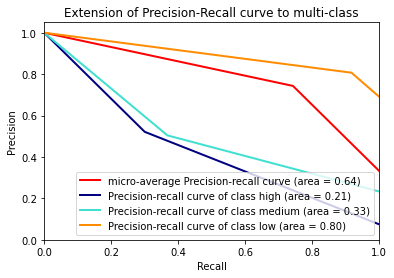

In [94]:
from itertools import cycle
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
precision["micro"], recall["micro"], _ = precision_recall_curve(y.ravel(),score.ravel())
average_precision["micro"] = average_precision_score(y, score,average="micro")

plt.clf()
plt.plot(recall["micro"], precision["micro"], color='red', lw=2,
         label='micro-average Precision-recall curve (area = {0:0.2f})'
               ''.format(average_precision["micro"]))
for i, color in zip(range(len(target_names)), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label='Precision-recall curve of class {0} (area = {1:0.2f})'
                   ''.format(target_names[i], average_precision[i]))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(loc="lower right")
plt.show()

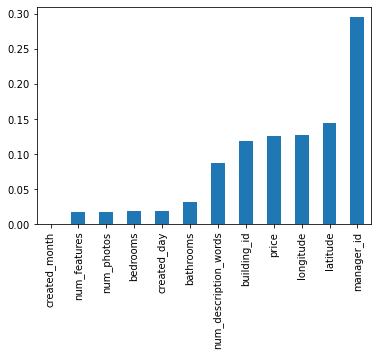

In [95]:
pd.Series(index = these_features, data = clf.feature_importances_).sort_values().plot(kind = 'bar')
plt.show()

In [96]:
y = label_binarize(y_val, classes=[0,1,2])
score = label_binarize(preds, classes=[0,1,2])

print(y[:,1])
print(score[:,1])

[0 0 0 ... 0 0 0]
[0 0 0 ... 1 1 0]


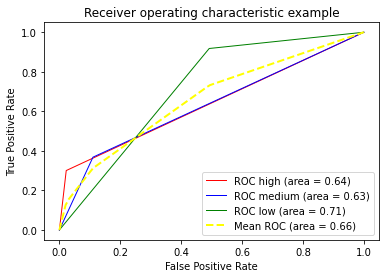

In [97]:
from sklearn.metrics import roc_curve, auc
import pandas as pd
from numpy import interp

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
labels = ['high','medium','low']
colors = ['red', 'blue', 'green', 'yellow']

for i in range(3):
    fpr, tpr, _ = roc_curve(y[:,i], score[:,i])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, color=colors[i],
             label='ROC %s (area = %0.2f)' % (labels[i], roc_auc))

mean_tpr /= 3
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='yellow', linestyle='--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()